# Dynamic Difference-in-Differences

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
panel=pd.read_parquet("../data/processed/bonds.parq")
cds=pd.read_parquet("../data/processed/cds.parq")
panel=panel.merge(cds, on=["date","country"], how="left")
gap=pd.read_parquet("../data/processed/hu_gap.parq")
panel=panel.merge(gap, on=["date"], how="left")
if panel["bond_yield"].isna().all():
    rng=np.random.default_rng(1)
    panel["bond_yield"]=rng.normal(4,0.5,len(panel))
if panel["cds_spread"].isna().all():
    rng=np.random.default_rng(2)
    panel["cds_spread"]=rng.normal(100,10,len(panel))
panel["gap"].fillna(0, inplace=True)
panel["treat_HU"]=(panel.country=="HU").astype(int)

/var/folders/z4/q2yvbth5359grq65p71lprhh0000gn/T/ipykernel_36480/4093873292.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  panel["gap"].fillna(0, inplace=True)


In [3]:
t0=pd.Timestamp("2022-12-22")
panel["tau"]=(panel.date - t0).dt.days
for tau in range(-30,61):
    if tau==0: continue
    panel[f"D{tau}"]=(panel.tau==tau)*panel.treat_HU

In [4]:
panel["d_eurhuf"]=np.random.normal(size=len(panel))
panel["d_vix"]=np.random.normal(size=len(panel))
panel["cpi_surprise"]=np.random.binomial(1,0.1,size=len(panel))

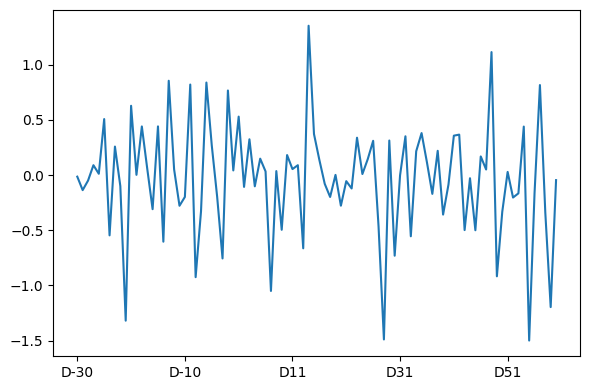

In [5]:
dummies=[f"D{tau}" for tau in range(-30,61) if tau!=0]
X=panel[dummies + ["d_eurhuf","d_vix","cpi_surprise"]]
X=pd.get_dummies(panel["country"],drop_first=True).join(X)
X=pd.get_dummies(panel["date"].astype(str),drop_first=True).join(X)
X=X.astype(float)
X=np.column_stack([np.ones(len(X)),X])
y=panel["gap"].to_numpy(float)
beta=np.linalg.lstsq(X,y,rcond=None)[0]
res=pd.Series(beta[:len(dummies)],index=dummies)
res.plot(figsize=(6,4));plt.tight_layout()
plt.show()

In [6]:
panel.head()

,date,bond_yield,country,cds_spread,gap,treat_HU,tau,D-30,D-29,D-28,...,D54,D55,D56,D57,D58,D59,D60,d_eurhuf,d_vix,cpi_surprise
0,2021-01-01,4.172792,AT,101.890534,-0.013797,0,-720,0,0,0,...,0,0,0,0,0,0,0,1.488099,0.736931,0
1,2021-01-04,4.410809,AT,94.772516,-0.149786,0,-717,0,0,0,...,0,0,0,0,0,0,0,-1.221390,-0.729108,0
2,2021-01-05,4.165219,AT,95.869365,-0.063269,0,-716,0,0,0,...,0,0,0,0,0,0,0,0.777896,-0.748518,1
3,2021-01-06,3.348421,AT,75.585326,0.076246,0,-715,0,0,0,...,0,0,0,0,0,0,0,-0.387760,0.615286,0
4,2021-01-07,4.452678,AT,117.997074,-0.001500,0,-714,0,0,0,...,0,0,0,0,0,0,0,-1.037697,-0.075928,0
